In [8]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [17]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    import pandas as pd
    rolled = pd.Series(values).rolling(window)
    std = np.array(rolled.std())
    mean = np.array(rolled.mean())
    # weights = np.repeat(1.0, window) / window
    return mean, std#np.convolve(values, weights, "valid"), std


def plot_results(log_folder, 
                 title="Learning Curve", 
                 label = None,
                 ):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y, std = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    if label is None:
        label = 'mean rewards $\pm 2\sigma$'
    plt.plot(x, y, label=label)
    plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.ylim((0.5,1))
    plt.title(title + " Smoothed")
    # plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    return x
    # plt.show()

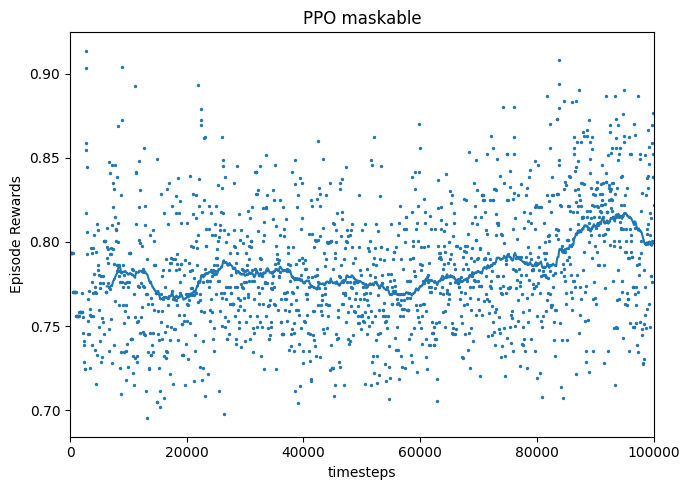

In [18]:
log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)'
# log_dir = f'./'
# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO maskable", (7, 5)
)

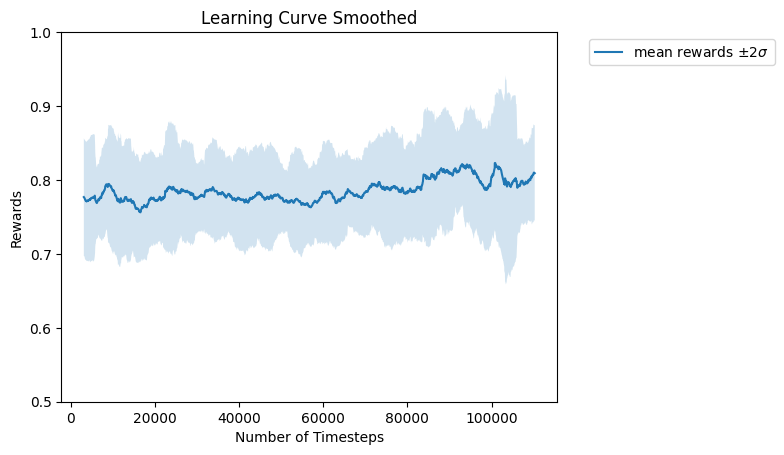

In [20]:
_ = plot_results(log_dir)

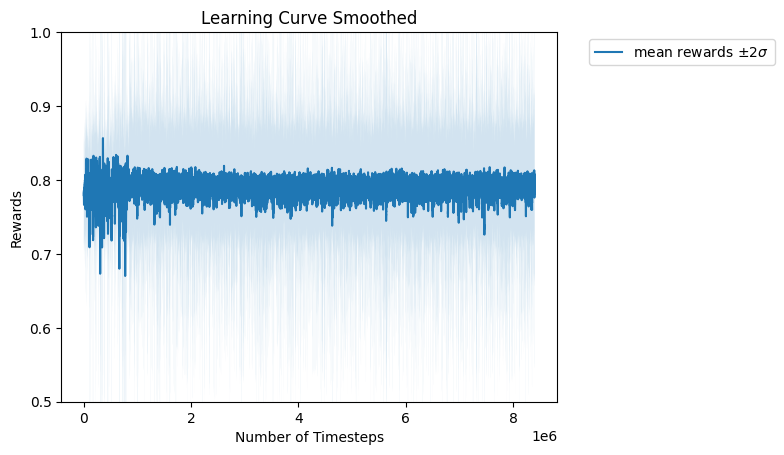

In [40]:
_ = plot_results('./')
# plt.savefig('long_run')

In [34]:
K = 100
import sys
import os
from copy import deepcopy
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv
import pickle

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'all_nodes',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = id)
env.reset()
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
action_A = res_A['solution'].astype(int)
a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(a)

env.reset()
a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(a)

a_GTS = res_GTS['solution']
env.reset()
a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(a)


A* evaluated 2275 different assignments
m = 85168
10020.0


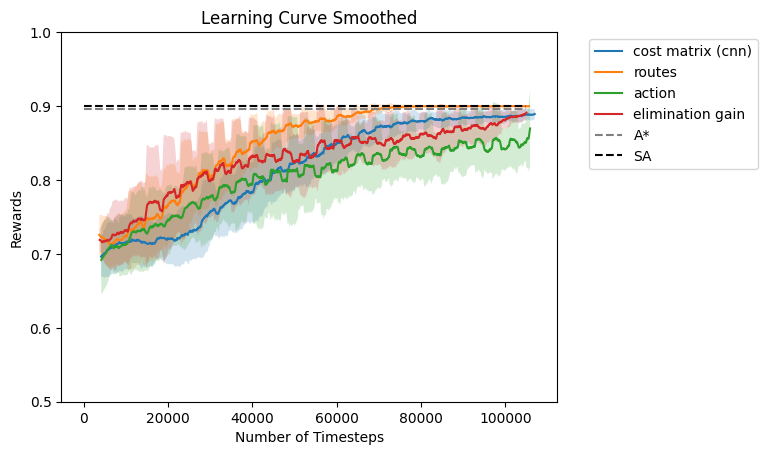

In [38]:
id = 0
_ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(cost_matrix)_steps(100000)_instanceID{id}/', label='cost matrix (cnn)')#, show_hlines=True)
_ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(100000)_instanceID{id}/', label='routes')#, show_hlines=True)
_ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(action)_steps(100000)_instanceID{id}/', label='action')#, show_hlines=True)
x = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)_instanceID{id}/', label='elimination gain')#, show_hlines=True)

plt.hlines(r_A, 0, x[-1], linestyles = '--', label='A*', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label='GTS', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '--', label='SA', colors='black')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig('RL')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


In [47]:
def add0(l):
    l.append(0)
    return l

l = [1, 2]
ll = add0(l)

[1, 2, 0]
[1, 2, 0]


In [5]:
log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50000)/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='v0 : [2048, 2048, 1024, 256]')
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51200)/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='v1 : [2048, 2048, 1024]')
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51000)/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='v2 : [1024, 1024, 256, 128]')
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51250)/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='v3 : [1024, 1024, 256, 128]', color='red')
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

plt.legend()

LoadMonitorResultsError: No monitor files of the form *monitor.csv found in ppo_mask/rewardMode(normalized_terminal)_steps(50000)/

In [ ]:
log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50002)_instanceID0/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
# Truncate x
col = 'red'
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='obs action', color=col)
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)


log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50001)_instanceID0/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
col = 'green'
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='obs normalized routes', color=col)
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)


log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50003)_instanceID0/'
x, y = ts2xy(load_results(log_folder), "timesteps")
y, std = moving_average(y, window=50)
col = 'purple'
# Truncate x
x = x[len(x) - len(y) :]
fig = plt.figure('title')
plt.plot(x, y, label='obs routes', color=col)
plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)

plt.legend()